# Study anomaly detection data from AWS
1. the system failure vs ambient temperature <br>
2. The failure/anomaly is a time interval rather than a data point <br>
3. Apply unsupervised method <br>
4. Evaluate the results based on this : https://github.com/numenta/NAB
5. This is a toy model: I only apply a K mean clustering method.


In [204]:
# import packages 
import xgboost
from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM


In [180]:
#data path
root_path = "Data//realKnownCause/realKnownCause/"
os.listdir(root_path)

['ambient_temperature_system_failure.csv',
 'cpu_utilization_asg_misconfiguration.csv',
 'ec2_request_latency_system_failure.csv',
 'machine_temperature_system_failure.csv',
 'nyc_taxi.csv',
 'rogue_agent_key_hold.csv',
 'rogue_agent_key_updown.csv']

In [181]:
## Some hyper-parameters:

n_clusters = 15
anomaly_ratio = 0.5


In [182]:
df = pd.read_csv(root_path+'ambient_temperature_system_failure.csv')

In [194]:
print(df['timestamp'].head(10))

0   2013-07-04 00:00:00
1   2013-07-04 01:00:00
2   2013-07-04 02:00:00
3   2013-07-04 03:00:00
4   2013-07-04 04:00:00
5   2013-07-04 05:00:00
6   2013-07-04 06:00:00
7   2013-07-04 07:00:00
8   2013-07-04 08:00:00
9   2013-07-04 09:00:00
Name: timestamp, dtype: datetime64[ns]


W0629 15:47:02.740685 140145137620800 legend.py:1247] No handles with labels found to put in legend.


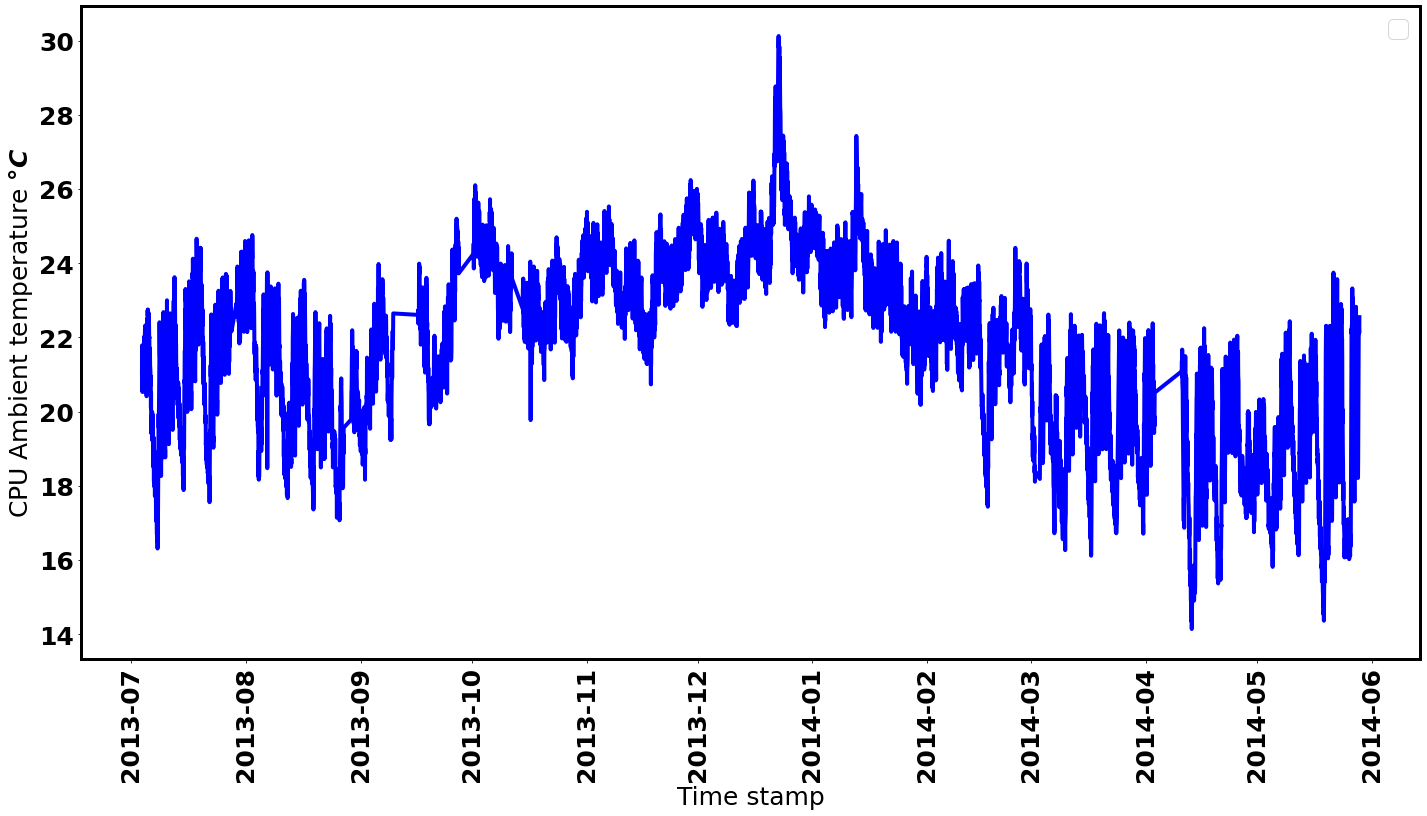

In [195]:
from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


# plot the data using Celcius
#df.plot(x='timestamp', y='value')

plt.plot(df['timestamp'],df['value'],"b",linewidth=4)


plt.xlabel("Time stamp")
plt.ylabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

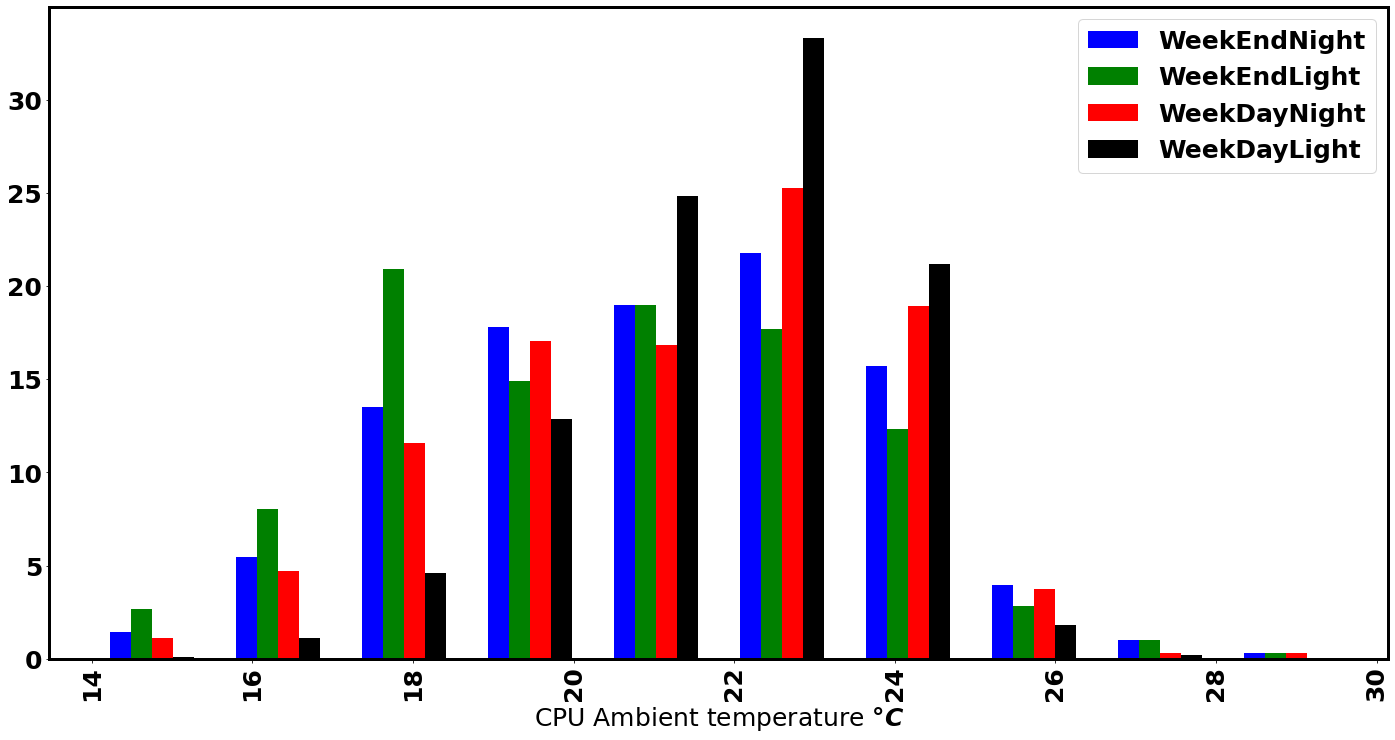

In [228]:
# Let's consider the correlation between weekday/hour/season vs failure
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')




plt.xlabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

plt.show()


W0629 15:49:26.504628 140145137620800 legend.py:1247] No handles with labels found to put in legend.


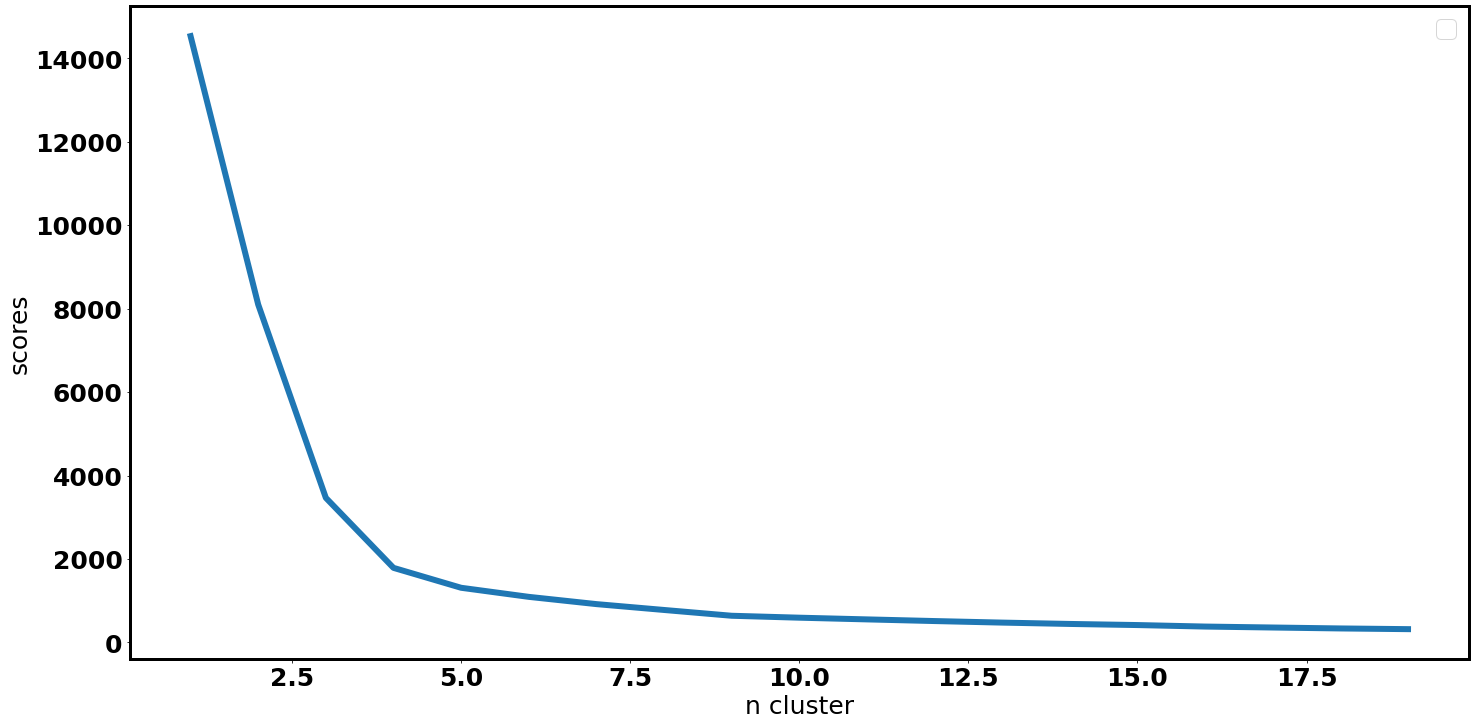

In [205]:
# Take useful feature and standardize them

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
scores = np.array(scores)
ax.plot(n_cluster, abs(scores),linewidth=6)



plt.xlabel("n cluster")
plt.ylabel(r"scores")

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

plt.show()



In [206]:
# Let's take a look at the previous plot: Choose around 10-15 clusters:
# predict each clustering


df['cluster'] = kmeans[n_clusters-1].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

11    661
12    648
4     648
1     616
3     596
5     576
7     572
0     401
10    399
2     397
14    366
6     356
9     354
13    339
8     338
Name: cluster, dtype: int64

W0629 15:52:05.687510 140145137620800 legend.py:1247] No handles with labels found to put in legend.


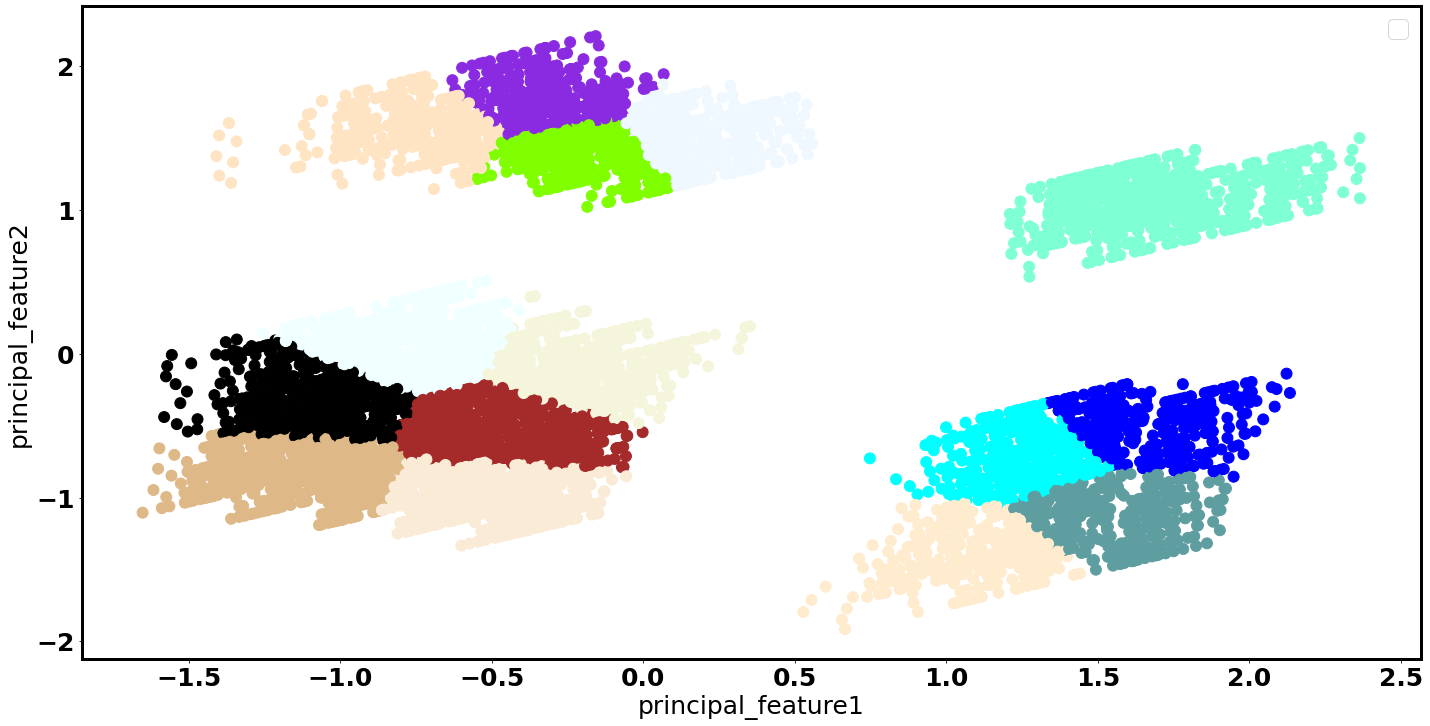

In [222]:
#plot the different clusters with the 2 main features

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

from matplotlib import colors as mcolors
fig, ax = plt.subplots()
colors = dict()
for i in range(len(list(mcolors.CSS4_COLORS.keys()))):
    colors[i]=list(mcolors.CSS4_COLORS.keys())[i]


ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]),s=120)

plt.xlabel('principal_feature1')
plt.ylabel('principal_feature2')

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

plt.show()


In [223]:
### Consider the points that have the largest distance between centroid of that cluster as anomaly:
# calculate the centroid for each cluster first:

# squared distance to cluster center
centroids = kmeans[n_clusters-1].cluster_centers_
def distance(x):
    # return kmeans[x["cluster"]].transform(np.atleast_2d([x['principal_feature1'],x['principal_feature2']]))**2
    return (centroids[x["cluster"],0]-x['principal_feature1'])**2+(centroids[x["cluster"],1]-x['principal_feature2'])**2
df["D"]=df.apply(lambda x : distance(x),axis=1)

In [231]:
# Here "D" is the distance for each row to the centroids of each group
# Let's choose 2% data as anomaly ones

#!!! different kind of masks

mask = df["D"]>np.nanpercentile(df["D"],100-anomaly_ratio)

number_of_outliers=int(len(df["D"])*anomaly_ratio/100)
threshold = df["D"].nlargest(number_of_outliers).min()


W0629 15:56:52.403011 140145137620800 legend.py:1247] No handles with labels found to put in legend.


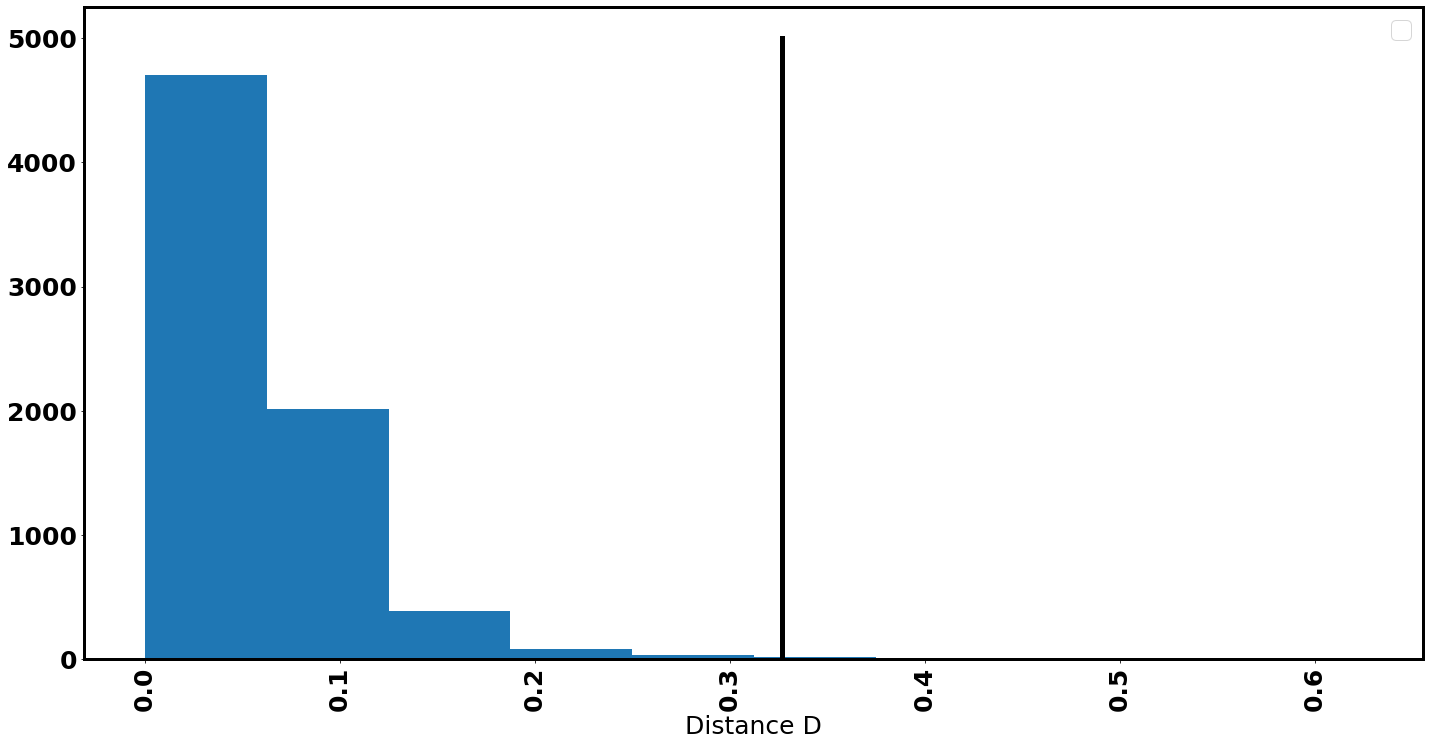

In [234]:


from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


# plot the data using Celcius
#df.plot(x='timestamp', y='value')

plt.hist(df["D"])

plt.plot([threshold,threshold],[0,5000],"k",linewidth=5)


plt.xlabel("Distance D")

plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()

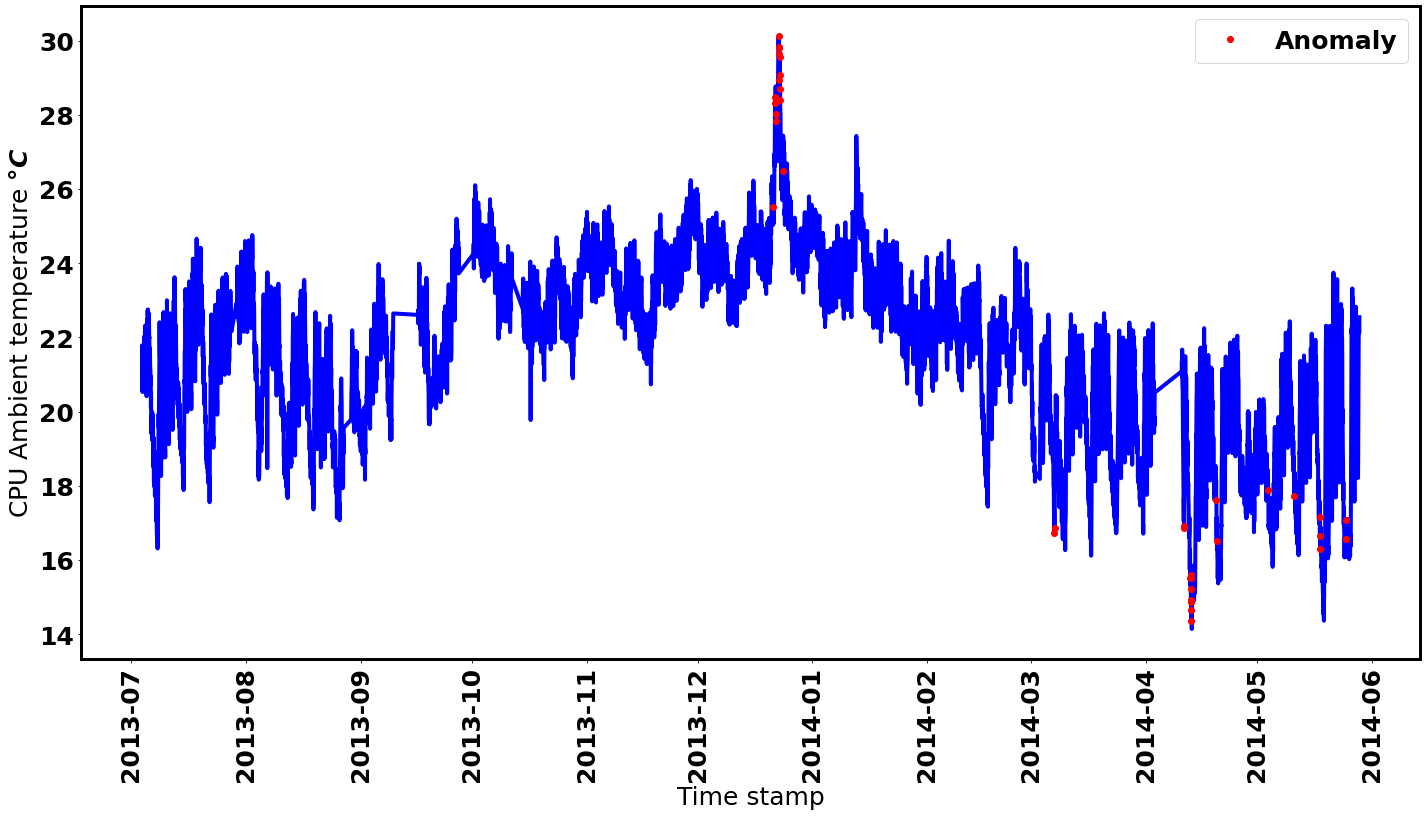

In [225]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


# plot the data using Celcius
#df.plot(x='timestamp', y='value')

plt.plot(df['timestamp'],df['value'],"b",linewidth=4)

plt.plot(df[mask]['timestamp'],df[mask]['value'],"ro",linewidth=4,label="Anomaly")

plt.xlabel("Time stamp")
plt.ylabel(r"CPU Ambient temperature $\degree C$")
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,12)
plt.legend()